In [1]:
from high_low_xuejieZuhui import *
import datetime
from tqdm import tqdm

In [2]:
filename = '000001.SZ.csv'
df = df_init(filename)
dic_init()
peaks, valleys, high_points, low_points = find_high_low_xuejieZuhui(df, filename, 200, draw=False)

/Users/kai/Desktop/qs/data_csv_distinct_0606/000001.SZ.csv


In [4]:
def find_horizontal_area(df, high_points, low_points, max_len_of_window=30, min_len_of_window=10, gamma=0.4, view_coe=1, ignore_hl=True):
    """
    此函数的输出为一个dataframe，包含以下列：start_date, end_date, start_price, end_price, price_change, interval
    横盘的定义是：此段区间内价格变化不超过滑动窗口内最大价格变化的40%；滑动窗口的定义是从start_date向前数10天，到end_date向后数10天
    此函数的输出是一支股票所有的横盘区域
    """

    print('当前参数组合: max_len_of_window = {}, min_len_of_window = {}, gamma = {}'.format(
        max_len_of_window, min_len_of_window, gamma))

    result = pd.DataFrame(columns=[
                          'start_date', 'end_date', 'start_price', 'end_price', 'price_change', 'interval'])

    # 循环遍历每个高点和低点，确定横盘区间的起止日期，起始价格和结束价格
    index = 0
    for i in tqdm(range(len(df))):
        if i < index:
            continue
        for j in range(min_len_of_window+1, max_len_of_window+1):
            if i+j >= len(df):
                break
            start_date = df.iloc[i]['TRADE_DT']
            end_date = df.iloc[i+j]['TRADE_DT']

            # 判断横盘区间是否包含 high_points 和 low_points 中的点
            if ignore_hl:
                if any([high['high_date'] >= start_date and high['high_date'] <= end_date for high in high_points]):
                    continue
                if any([low['low_date'] >= start_date and low['low_date'] <= end_date for low in low_points]):
                    continue

            # 使用start date, end date, start peice, end price计算滑动窗口内的最大价格变化（窗口内所有价格的最高点减去最低点）
            start_date_window = start_date - \
                datetime.timedelta(days=max_len_of_window*view_coe)
            end_date_window = end_date + \
                datetime.timedelta(days=max_len_of_window*view_coe)
            max_change = df[(df['TRADE_DT'] >= start_date_window) & (df['TRADE_DT'] <= end_date_window)]['S_DQ_CLOSE'].max(
            ) - df[(df['TRADE_DT'] >= start_date_window) & (df['TRADE_DT'] <= end_date_window)]['S_DQ_CLOSE'].min()

            # 计算横盘区间的价格变化和区间长度
            # price_change 是横盘区间内所有价格中最大价格减去最小价格，你需要遍历所有价格
            high_price = df[(df['TRADE_DT'] >= start_date) & (
                df['TRADE_DT'] <= end_date)]['S_DQ_CLOSE'].max()
            low_price = df[(df['TRADE_DT'] >= start_date) & (
                df['TRADE_DT'] <= end_date)]['S_DQ_CLOSE'].min()
            price_change = high_price - low_price
            interval = (end_date - start_date).days

            # 判断区间是否为横盘，如果是则将信息添加到 DataFrame 中
            if abs(price_change) <= gamma * max_change:
                result = result.append({'start_date': start_date,
                                        'end_date': end_date,
                                        'high_price': high_price,
                                        'low_price': low_price,
                                        'price_change': price_change,
                                        'interval': interval}, ignore_index=True)
                index = i+j
    print('len of result:', len(result))
    print('mean of interval:', result['interval'].mean())
    result['interval'].plot.hist(bins=20)
    return result


In [5]:
def draw_horizontal_area(df, result, peaks, valleys, high_points, low_points, n_days=100, print_result=True):
    # 获取最后100天的数据
    last_hundred_days_df = df.tail(n_days)
    # 绘制折线图
    plt.plot(last_hundred_days_df['TRADE_DT'],
            last_hundred_days_df['S_DQ_CLOSE'], color='royalblue', label='stock price', alpha=0.8)
    # 将last_hundred_days_df['TRADE_DT']转换为与peaks中日期格式相同的字符串格式
    last_hundred_days_dates = last_hundred_days_df['TRADE_DT'].dt.strftime(
        '%Y-%m-%d')
    # 提取最后100天内的峰值和谷值
    last_hundred_days_peaks = [peak for peak in peaks if peak['date'].strftime(
        '%Y-%m-%d') in last_hundred_days_dates.values]
    last_hundred_days_valleys = [valley for valley in valleys if valley['date'].strftime(
        '%Y-%m-%d') in last_hundred_days_dates.values]

    # 提取最后100天内的高点和低点
    last_hundred_days_high = [high_point for high_point in high_points if high_point['high_date'].strftime(
        '%Y-%m-%d') in last_hundred_days_dates.values]
    last_hundred_days_low = [low_point for low_point in low_points if low_point['low_date'].strftime(
        '%Y-%m-%d') in last_hundred_days_dates.values]


    # 标记峰值和谷值
    for peak in last_hundred_days_peaks:
        plt.scatter(peak['date'], peak['price'], color='red',
                    marker='^', label='Peak', alpha=0.3)
    for valley in last_hundred_days_valleys:
        plt.scatter(valley['date'], valley['price'],
                    color='green', marker='v', label='Valley', alpha=0.3)

    # 标记高点和低点
    for high_point in last_hundred_days_high:
        plt.scatter(high_point['high_date'], high_point['high_price'],
                    color='red', marker='*', label='high', s=80)
    for low_point in last_hundred_days_low:
        plt.scatter(low_point['low_date'], low_point['low_price'],
                    color='green', marker='*', label='low', s=80)

    # 使用plt.axvspan方法绘制横盘区间，参数为alpha=0.3, color='green'，确保仅绘制最后100天内的横盘区间
    result = result.drop_duplicates(subset=['start_date'])
    for i in range(len(result)):
        if result['start_date'].iloc[i] - pd.to_datetime('2023-06-06',format="%Y-%m-%d") > -datetime.timedelta(days=1.4*n_days):
            if print_result:
                print(result['start_date'].iloc[i])
                print(result['end_date'].iloc[i])
                print(result['interval'].iloc[i])
                print
                print('---')
            plt.axvspan(result['start_date'].iloc[i], result['end_date'].iloc[i],
                        alpha=0.3, color='green')

    # 设置图形标题和标签
    plt.title('Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    # 获取当前图形中的所有句柄和标签
    handles, labels = plt.gca().get_legend_handles_labels()

    # 去除重复的标签
    unique_labels = set(labels)

    # 创建新的标签和句柄列表, 其中元素按照'stock price', 'Peak', 'Valley', 'high', 'low'的顺序排列
    new_labels = ['stock price', 'Peak', 'Valley', 'high', 'low']
    new_handles = []
    for new_label in new_labels:
        for i in range(len(labels)):
            if labels[i] == new_label:
                new_handles.append(handles[i])
                break

    plt.legend(handles=new_handles, labels=new_labels)
    plt.show()

当前参数组合: max_len_of_window = 40, min_len_of_window = 12, gamma = 0.3


100%|██████████| 5676/5676 [00:31<00:00, 182.95it/s]

len of result: 468
mean of interval: 28.132478632478634


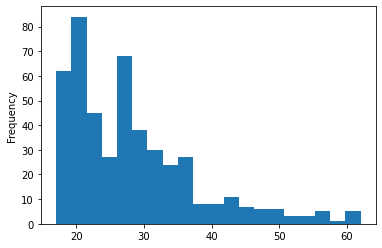

In [6]:
max_len_of_window = 40
min_len_of_window = 12
gamma = 0.3  # 最大变化率
view_coe = 0.8  # 视野系数

result = find_horizontal_area(df, high_points, low_points, max_len_of_window, min_len_of_window, gamma, view_coe, ignore_hl=True)

2022-05-23 00:00:00
2022-06-20 00:00:00
28
---
2022-06-23 00:00:00
2022-07-12 00:00:00
19
---
2022-08-11 00:00:00
2022-08-30 00:00:00
19
---
2022-12-12 00:00:00
2022-12-29 00:00:00
17
---
2023-03-09 00:00:00
2023-03-28 00:00:00
19
---
2023-03-30 00:00:00
2023-04-19 00:00:00
20
---


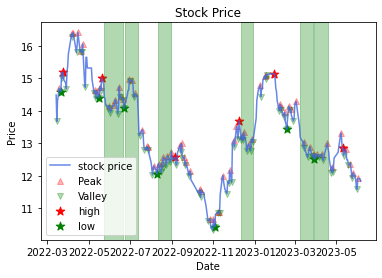

In [7]:
n_days=300
draw_horizontal_area(df, result, peaks, valleys, high_points, low_points, n_days, print_result=True)